Projeto Séries Temporais
Aluno João Paulo Barbosa

# Objetivos

1. Descrever a série temporal de acordo com as suas componentes e propriedades.
Desde a tendência, sazonalidade, heterocedastidade, entre outros.

2. Descrever a estrutura ARIMA que melhor se adequa aos dados

3. Avaliar diferentes métodos de aprendizagem máquina com validação cruzada.

4. Analisar os resultados obtidos no ponto 3. Descrever o impacto dos seguintes aspetos no desempenho preditivo: a) diferentes horizontes de previsão, b) desempenho nos valores extremos, diferentes algoritmos de aprendizagem máquina

In [1]:
import pandas as pd
%matplotlib inline

In [2]:
# https://github.com/vcerqueira/energy_load_data
data = pd.read_csv('energy_load_pt.csv')
# dimensão dos dados
data.shape

(13104, 2)

In [3]:
data.head()

,datetime,load
0,2020-11-17 08:00:00,5159.0
1,2020-11-17 09:00:00,4985.0
2,2020-11-17 10:00:00,4717.0
3,2020-11-17 11:00:00,4356.0
4,2020-11-17 12:00:00,4086.0


<Axes: xlabel='datetime'>

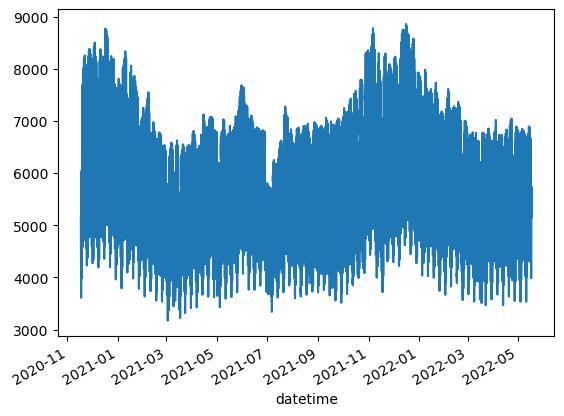

In [4]:
series = pd.Series(data['load'])
series.index = pd.to_datetime(data['datetime'])
series.plot()

<Axes: xlabel='datetime'>

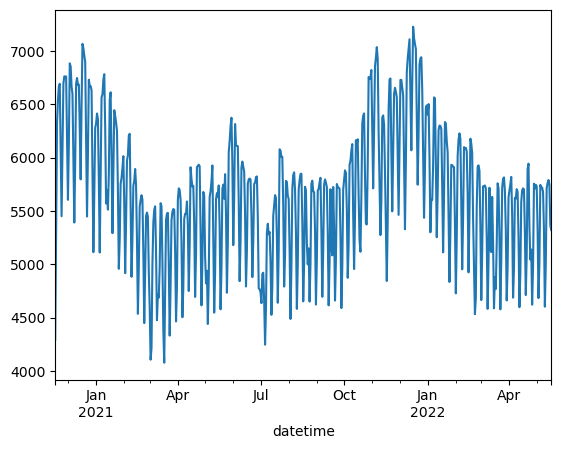

In [5]:
series.resample('D').mean().plot()

<Axes: >

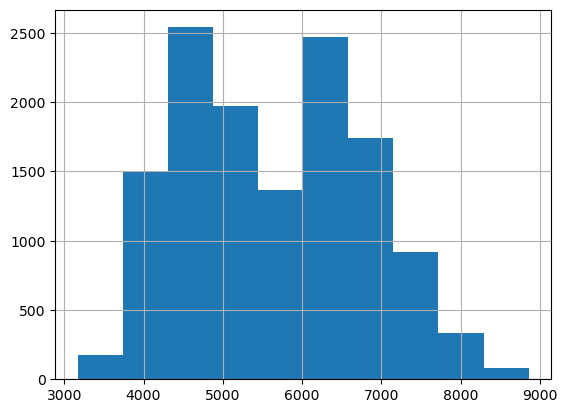

In [6]:
series.hist()

In [7]:
!pip install pmdarima

In [8]:
series.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 13104 entries, 2020-11-17 08:00:00 to 2022-05-17 08:00:00
Series name: load
Non-Null Count  Dtype  
--------------  -----  
13102 non-null  float64
dtypes: float64(1)
memory usage: 204.8 KB


In [9]:
indices_nan = series.index[series.isna()]
print("Linhas onde ocorrem os valores NaN:", indices_nan)


Linhas onde ocorrem os valores NaN: DatetimeIndex(['2021-02-09 10:00:00', '2022-02-08 10:00:00'], dtype='datetime64[ns]', name='datetime', freq=None)


Encontrei duas linhas com valores NAN, vamos preencher estas linhas com os valore da celula anterior, utilizando ffill.

In [10]:
series_full = series.fillna(method='ffill')

In [11]:
series_full.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 13104 entries, 2020-11-17 08:00:00 to 2022-05-17 08:00:00
Series name: load
Non-Null Count  Dtype  
--------------  -----  
13104 non-null  float64
dtypes: float64(1)
memory usage: 204.8 KB


In [12]:
from pmdarima.arima import ndiffs, nsdiffs

Testes para identificar tendência

In [13]:
ndiffs(series_full, test='kpss')

1

In [14]:
ndiffs(series_full, test='adf')

0

In [15]:
ndiffs(series_full, test='pp')

0

Destre os três testes realizados para identificar tendência, dois resultaram a não ocorrência de tendência, por isso vamos considerar que não há tendência na série.


<Axes: xlabel='datetime'>

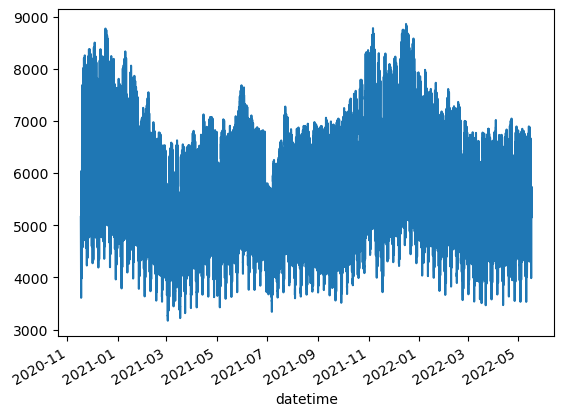

In [16]:
series_full.plot()

Testes para identificar sazonalidade, considerando o período diário

In [17]:
nsdiffs(series_full, test='ocsb', m=24)

0

In [18]:
nsdiffs(series_full, test='ch', m=24)

1

Um teste indica que há sazonalidade e outro indica que não há, devido à característica do dataset, vamos considerar que há sazonalidade. 

<Axes: xlabel='datetime'>

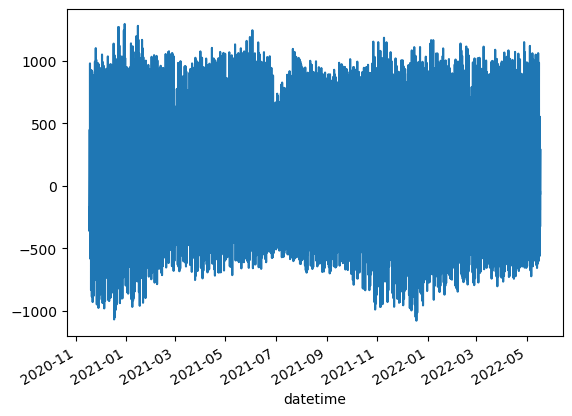

In [19]:
# removendo a tendencia
series_full.diff(periods=1).plot()

<Axes: xlabel='datetime'>

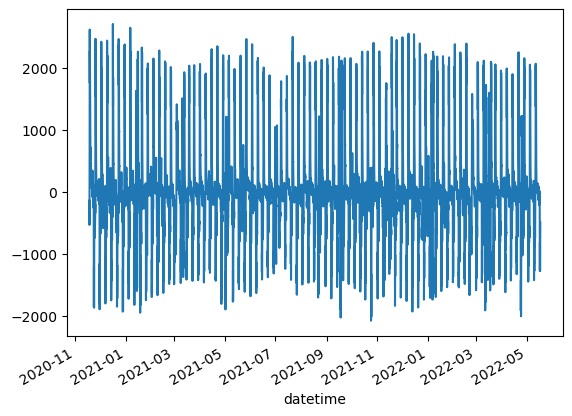

In [20]:
# removendo a sazonalidade
series_full.diff(periods=24).plot()

<Axes: xlabel='datetime'>

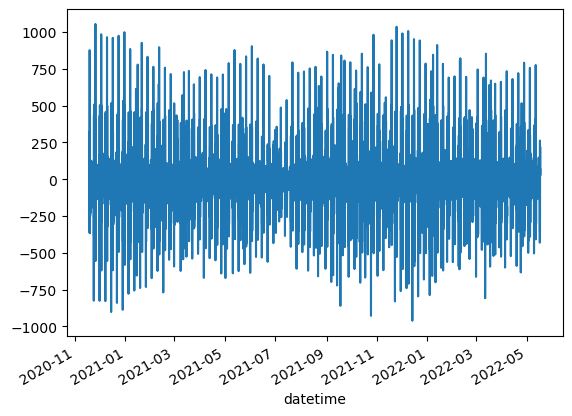

In [21]:
# residuos
series_full.diff(periods=1).diff(periods=24).plot()

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

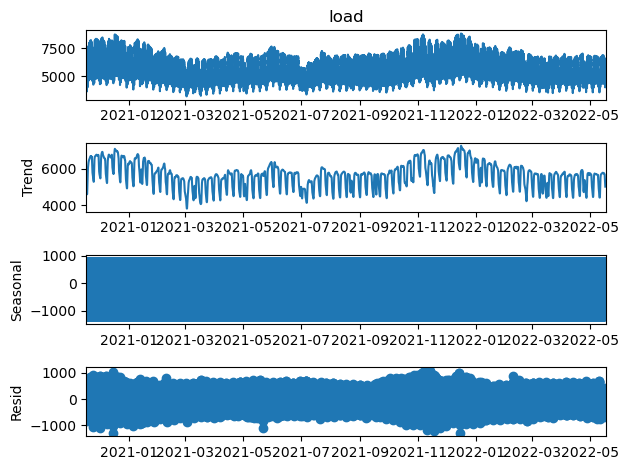

In [24]:
result = seasonal_decompose(series_full,
                            model='additive',
                            period=24)

plt = result.plot()

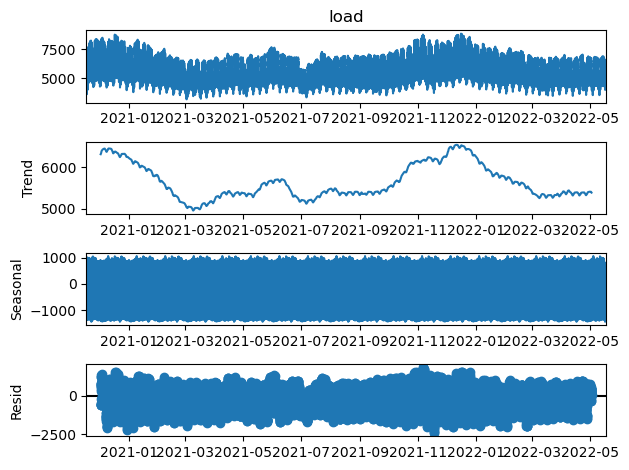

In [25]:
resultm = seasonal_decompose(series_full,
                            model='additive',
                            period=24*30)

plt = resultm.plot()

Entendemos até o momento que a série não apresenta tendência, entretanto apresenta sazonalidade, que pode ser mais perceptível em perídos mensais. O problema da série é que ela não contempla três anos inteniros, inicia em 11/2020 e termina em 05/2022, por isso a identificação de tendência e sazonalidade fica mais difícil.

Vejamos agora os indicadores de auto-correlação e estacionariedade

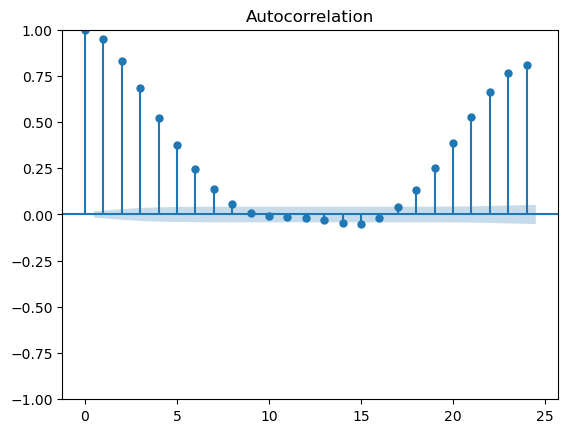

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt = plot_acf(series_full, lags=24)

O indicador de auto-correlação demonstra que no período de 24 horas existem correlações significativas entre os dados, demonstram também a sazonalidade que existe dentro deste período

In [27]:
from statsmodels.tsa.stattools import adfuller

In [28]:
resultado_adf = adfuller(series_full, autolag='AIC')

In [29]:
print('Resultado do Teste ADF:')
print('Estatística ADF:', resultado_adf[0])
print('p-valor:', resultado_adf[1])
print('Valores críticos:')
for chave, valor in resultado_adf[4].items():
    print(f'   {chave}: {valor}')

if resultado_adf[1] <= 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Resultado do Teste ADF:
Estatística ADF: -12.446654866324831
p-valor: 3.6518949605992385e-23
Valores críticos:
   1%: -3.4308506188497576
   5%: -2.8617612494685436
   10%: -2.566887766169301
A série é estacionária.


Os indicadores de estacionariedade indicam que a série é estacionário, o que corrobora a ausência de tendência identificada anteriormente.

Vamos agora aplicar o modelo auto arima, que irá automaticamente identificar os parametros de otimização do modelo, visando a minimização do AIC.

In [32]:
# divisao entre treino e validacao
from sklearn.model_selection import train_test_split
# utilizaremos um tamanho de teste de 20% dos dados disponíveis.
train, test = train_test_split(series_full, shuffle=False, test_size=0.2)

In [31]:
import pmdarima as pm

In [33]:
#utilizaremos um período diário (24horas)
model = pm.auto_arima(train, m=24, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic


C:\Users\joaop\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,2)(1,0,1)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\joaop\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\joaop\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\joaop\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\joaop\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\joaop\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "C:\U

 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=153695.636, Time=0.26 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=inf, Time=21.65 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=140877.631, Time=18.05 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=153693.637, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=148863.823, Time=2.52 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=64.82 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=137715.170, Time=71.92 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=93.40 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=inf, Time=67.82 sec


MemoryError: Unable to allocate 208. MiB for an array with shape (51, 51, 10484) and data type float64

Houve um problema de memória, vamos tealizar o reshape dos dados para perídos diários e tentar rodar o auto-arima novamente.

In [39]:
series_d = series_full.resample('D').mean()

In [40]:
series_d.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 547 entries, 2020-11-17 to 2022-05-17
Freq: D
Series name: load
Non-Null Count  Dtype  
--------------  -----  
547 non-null    float64
dtypes: float64(1)
memory usage: 8.5 KB


In [70]:
train, test = train_test_split(series_d, shuffle=False, test_size=110)


In [71]:
model = pm.auto_arima(train, m=30, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=6181.541, Time=3.46 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=6571.138, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=6466.546, Time=0.78 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=6320.805, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=6569.169, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=6186.792, Time=2.22 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=6198.681, Time=2.65 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=6182.845, Time=11.15 sec
 ARIMA(2,1,2)(1,0,2)[30] intercept   : AIC=inf, Time=13.52 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=6221.364, Time=0.44 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=6180.595, Time=9.77 sec
 ARIMA(1,1,2)(0,0,2)[30] intercept   : AIC=6201.479, Time=8.23 sec
 ARIMA(2,1,1)(0,0,2)[30] intercept   : AIC=6272.296, Time=5.60 sec
 ARIMA(3,1,2)(0,0,2)[30] intercept   : AIC=6169.356, Time=13.28 sec
 ARIMA(3,1,2)(0,0,1)[

In [ ]:
O modelo ARIMA que melhor se ajusta aos dados é o ARIMA(5,1,2)(0,0,0).

In [72]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  437
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2952.624
Date:                Sat, 29 Jul 2023   AIC                           5921.247
Time:                        15:27:28   BIC                           5953.868
Sample:                    11-17-2020   HQIC                          5934.121
                         - 01-27-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3039      0.077      3.956      0.000       0.153       0.454
ar.L2         -0.9909      0.062    -16.020      0.000      -1.112      -0.870
ar.L3          0.0641      0.094      0.680      0.497      -0.121       0.249
ar.L4         -0.5392      0.054    -10.000      0.000      -0.645      -0.433
ar.L5         -0.4391      0.065     -6.782      0.000      -0.566      -0.312
ma.L1         -0.1421      0.081     -1.753      0.080      -0.301       0.017
ma.L2          0.4131      0.062      6.669      0.000       0.292       0.534
sigma2      4.314e+04   2247.625     19.191      0.000    3.87e+04    4.75e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                75.19
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.09
Prob(H) (two-sided):                  0.87   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

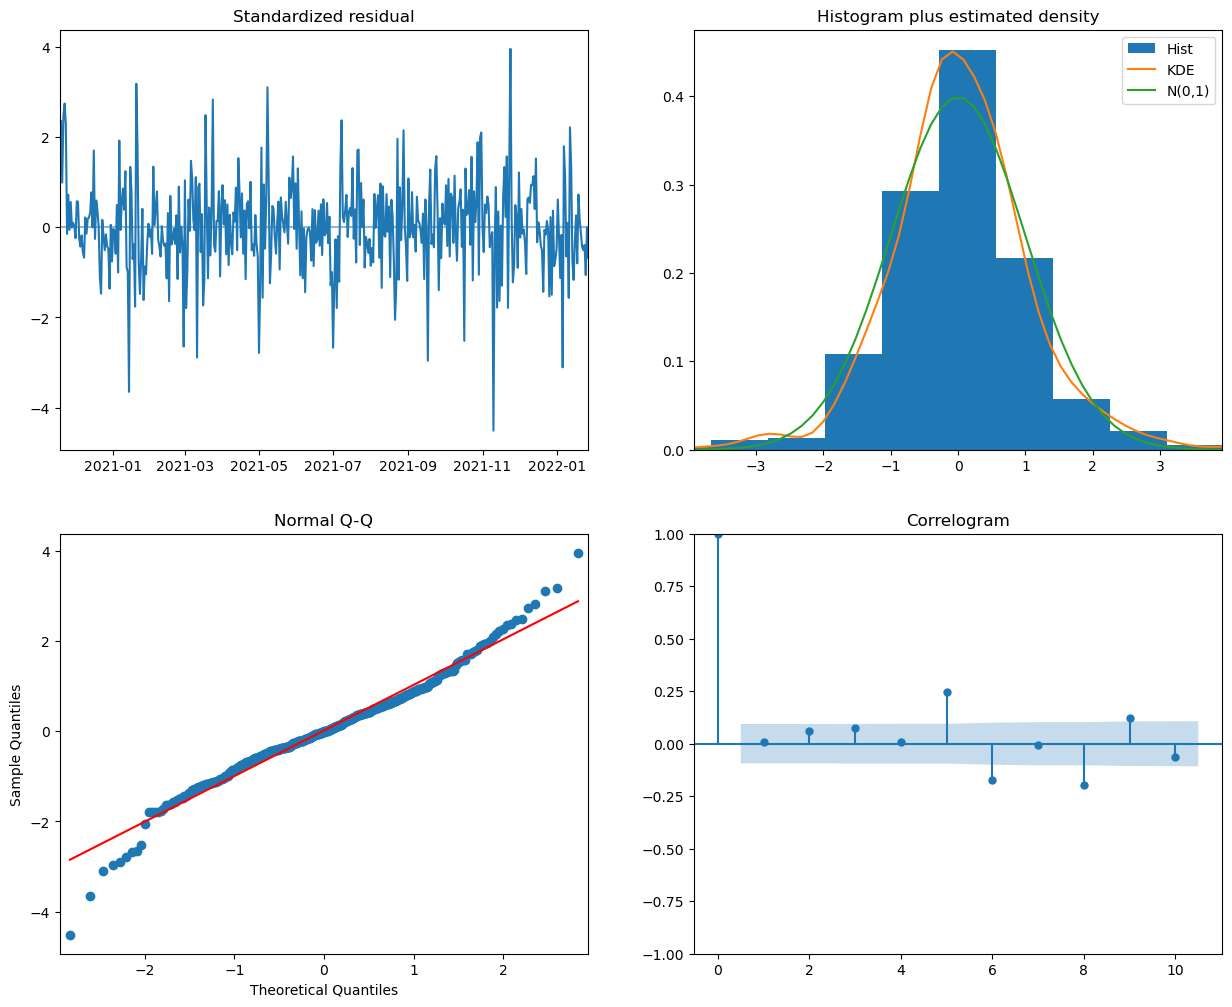

In [73]:
plot=model.plot_diagnostics(figsize=(15, 12))

Percebemos que os resíduos estão distribuídos seguindo uma ditribuição normal e que existe baixa correlação entre os resíduos. O que demonstra uma boa adaptabilidade do modelo.

In [74]:
forecasts = model.predict(110)
forecasts

2022-01-28    6001.162097
2022-01-29    5964.244578
2022-01-30    5953.788610
2022-01-31    5446.680941
2022-02-01    4986.452005
                 ...     
2022-05-13    5693.320291
2022-05-14    5684.450947
2022-05-15    5660.249484
2022-05-16    5619.982303
2022-05-17    5593.655349
Freq: D, Length: 110, dtype: float64

<Axes: title={'center': 'Forecasting with Auto Arima'}, xlabel='datetime'>

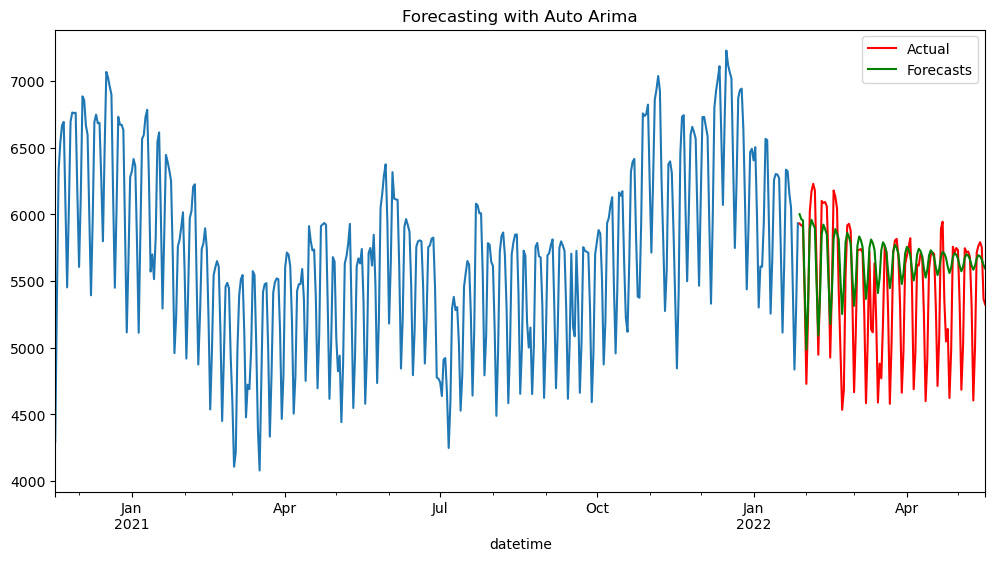

In [75]:
test = test.rename('Actual')
forecasts = pd.Series(forecasts, index=test.index).rename('Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with Auto Arima')
forecasts.plot(legend=True, color='green')

Vamos agora calcular o erro do modelo ARIMA

In [60]:
!pip install sktime

     ---------------------------------------- 17.1/17.1 MB 8.6 MB/s eta 0:00:00
     -------------------------------------- 118.2/118.2 kB 6.7 MB/s eta 0:00:00


In [61]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [94]:
test_serie = pd.Series(test)
forecasts_serie = pd.Series(forecasts)
train_serie = pd.Series(train)

In [95]:
mean_absolute_scaled_error(test_serie, forecasts_serie, y_train=train_serie)

0.8130904903222721

Neste caso o MASE menor que 1 indica que o modelo é melhor que um modelo NAIVE, entretanto ainda é um erro muito alto, que demonstra uma baixa capacidade de previsão.

Agora vamos iniciar a análise da previsão utilizando métodos de ML baseados em regressão

In [132]:
from SRC.tde import UnivariateTDE

Primeiro vamos transformar a série em uma matriz, com a expectativa de previsão de consumo no próximo dia com base nos últimos 18 dias.

In [141]:
series_tde = UnivariateTDE(data=series_d, k=18, horizon=1)

In [142]:
series_tde.head()

,t-17,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t-0,t+1
0,4294.687500,5373.125000,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000,5605.333333,6134.000000,6884.000000,6855.291667,6666.666667
1,5373.125000,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000,5605.333333,6134.000000,6884.000000,6855.291667,6666.666667,6596.750000
2,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000,5605.333333,6134.000000,6884.000000,6855.291667,6666.666667,6596.750000,5977.166667
3,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000,5605.333333,6134.000000,6884.000000,6855.291667,6666.666667,6596.750000,5977.166667,5392.750000
4,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000,5605.333333,6134.000000,6884.000000,6855.291667,6666.666667,6596.750000,5977.166667,5392.750000,5955.916667


In [ ]:
Separando as variaveis explicativas e target e criando os grupos de treino e teste

In [143]:
X = series_tde.drop('t+1', axis=1)
y = series_tde['t+1']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

Aplicando a técnica de validação cruzada dividindo a base em 5 e utilizando o modelo de regressão de ridge

In [96]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [145]:
cv = TimeSeriesSplit(n_splits=5)

cv_err = []
for tr_idx, ts_idx in cv.split(X_train, y_train):
    print('Training indices:')
    print(tr_idx[-5:])
    X_tr = X_train.values[tr_idx]
    y_tr = y_train.values[tr_idx]

    X_vl = X_train.values[ts_idx]
    y_vl = y_train.values[ts_idx]

    print('Training the model')
    model = Ridge()

    model.fit(X_tr, y_tr)
    print('Making predictions')
    pred = model.predict(X_vl)

    print('Computing error')
    err = mean_absolute_error(y_vl, pred)
    cv_err.append(err)

    
print(cv_err)

Training indices:
[60 61 62 63 64]
Training the model
Making predictions
Computing error
Training indices:
[121 122 123 124 125]
Training the model
Making predictions
Computing error
Training indices:
[182 183 184 185 186]
Training the model
Making predictions
Computing error
Training indices:
[243 244 245 246 247]
Training the model
Making predictions
Computing error
Training indices:
[304 305 306 307 308]
Training the model
Making predictions
Computing error
[144.71069729243558, 117.67365936476945, 93.87407717462051, 109.22691499957895, 188.85921135684563]


In [146]:
# erro estimado em validação cruzada
print(f'Average error is: {np.mean(cv_err)}')

Average error is: 130.86891203765003


In [147]:
# erro que obtemos no teste
model = Ridge()
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test)
print(f'Test error is: {err_test}')

Test error is: 125.23691652450476


Neste caso o erro obtido com a aplicação direta do teste é menor do que o erro utilizando-se validação cruzada, portanto não é indicada a validação cruzada para este modelo utilizando Ridge.

Vamos agora avaliar o desempenho de diferentes modelos de regressão utilizando validação cruzada.

In [148]:
model_list = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=10),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
}

from sklearn.model_selection import cross_val_score

In [149]:
err_by_method = {}
for method in model_list:
    print(f'Running model: {method}')
    cv_error = cross_val_score(model_list[method],
                               X_train,
                               y_train,
                               cv=cv,
                               scoring='neg_mean_absolute_error')

    err_by_method[method] = -np.mean(cv_error)

Running model: Ridge
Running model: Lasso
Running model: RandomForestRegressor


C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.437e+05, tolerance: 1.867e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+06, tolerance: 6.195e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e+06, toleranc

Running model: DecisionTreeRegressor
Running model: KNeighborsRegressor


<Axes: >

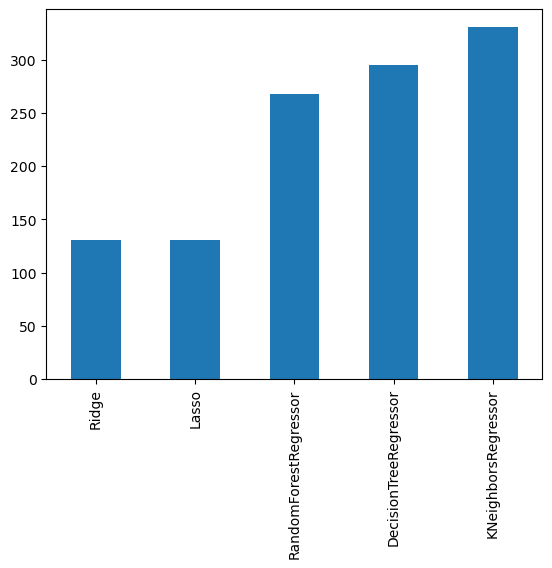

In [150]:
pd.Series(err_by_method).plot.bar()

In [151]:
from pprint import pprint
pprint(err_by_method)

{'DecisionTreeRegressor': 295.6632672843906,
 'KNeighborsRegressor': 331.02120622475655,
 'Lasso': 130.9431975692033,
 'RandomForestRegressor': 268.23349358517464,
 'Ridge': 130.86891203765077}


A comparação de diferentes métodos utilizando validação cruzada aponta que o método ridge ainda é o mais eficiente pois apresenta o menor erro médio. Entretanto o método Ridge aplicado de forma direta, sem validação cruzada, ainda apresenta a melhor performance.

Vamos agora comparar diferentes algoritmos de regressão, sem utilizar validação cruzada.

In [153]:
model = Ridge()
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test)
print(f'Test error is: {err_test}')

Test error is: 125.23691652450476


In [152]:
model = Lasso()
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test)
print(f'Test error is: {err_test}')

Test error is: 125.19552150418647


C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.326e+06, tolerance: 1.444e+04
  model = cd_fast.enet_coordinate_descent(


In [154]:
model = RandomForestRegressor(n_estimators=10)
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test)
print(f'Test error is: {err_test}')

Test error is: 167.75507548688978


In [157]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test)
print(f'Test error is: {err_test}')

Test error is: 183.59999468295203


In [158]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test)
print(f'Test error is: {err_test}')

Test error is: 167.6987892322182


Analisando o desempenho dos testes diretos, sem validação cruzada, o que apresenta melhor resultado segundo o indicador Erro médio absoluto é o modelo de Lasso.

In [ ]:
Iremos aplicar agora métodos multi step para previsões no longo prazo.

In [160]:
# prever os valores das próximas 14 dias com base nos últimos 42 dias
series_tde_long = UnivariateTDE(data=series_d, k=42, horizon=14)
series_tde_long.head()

,t-41,t-40,t-39,t-38,t-37,t-36,t-35,t-34,t-33,t-32,...,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14
0,4294.687500,5373.125000,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,...,6414.208333,6361.958333,5796.166667,5111.958333,5863.083333,6565.041667,6594.166667,6729.666667,6782.958333,6278.000000
1,5373.125000,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,...,6361.958333,5796.166667,5111.958333,5863.083333,6565.041667,6594.166667,6729.666667,6782.958333,6278.000000,5570.625000
2,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,...,5796.166667,5111.958333,5863.083333,6565.041667,6594.166667,6729.666667,6782.958333,6278.000000,5570.625000,5698.791667
3,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,...,5111.958333,5863.083333,6565.041667,6594.166667,6729.666667,6782.958333,6278.000000,5570.625000,5698.791667,5513.958333
4,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000,...,5863.083333,6565.041667,6594.166667,6729.666667,6782.958333,6278.000000,5570.625000,5698.791667,5513.958333,5833.958333


In [161]:
is_future = series_tde_long.columns.str.contains('\+')
X = series_tde_long.iloc[:,~is_future]
Y = series_tde_long.iloc[:,is_future]

X.head()

,t-41,t-40,t-39,t-38,t-37,t-36,t-35,t-34,t-33,t-32,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t-0
0,4294.687500,5373.125000,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,...,6957.416667,6898.250000,6132.708333,5449.291667,6034.208333,6730.708333,6671.166667,6670.916667,6632.125000,5883.083333
1,5373.125000,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,...,6898.250000,6132.708333,5449.291667,6034.208333,6730.708333,6671.166667,6670.916667,6632.125000,5883.083333,5114.833333
2,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,...,6132.708333,5449.291667,6034.208333,6730.708333,6671.166667,6670.916667,6632.125000,5883.083333,5114.833333,5656.625000
3,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,...,5449.291667,6034.208333,6730.708333,6671.166667,6670.916667,6632.125000,5883.083333,5114.833333,5656.625000,6279.208333
4,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000,...,6034.208333,6730.708333,6671.166667,6670.916667,6632.125000,5883.083333,5114.833333,5656.625000,6279.208333,6321.875000


In [162]:
Y.head()

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14
0,5114.833333,5656.625000,6279.208333,6321.875000,6414.208333,6361.958333,5796.166667,5111.958333,5863.083333,6565.041667,6594.166667,6729.666667,6782.958333,6278.000000
1,5656.625000,6279.208333,6321.875000,6414.208333,6361.958333,5796.166667,5111.958333,5863.083333,6565.041667,6594.166667,6729.666667,6782.958333,6278.000000,5570.625000
2,6279.208333,6321.875000,6414.208333,6361.958333,5796.166667,5111.958333,5863.083333,6565.041667,6594.166667,6729.666667,6782.958333,6278.000000,5570.625000,5698.791667
3,6321.875000,6414.208333,6361.958333,5796.166667,5111.958333,5863.083333,6565.041667,6594.166667,6729.666667,6782.958333,6278.000000,5570.625000,5698.791667,5513.958333
4,6414.208333,6361.958333,5796.166667,5111.958333,5863.083333,6565.041667,6594.166667,6729.666667,6782.958333,6278.000000,5570.625000,5698.791667,5513.958333,5833.958333


In [163]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)

Método Direto

In [165]:
from sklearn.multioutput import MultiOutputRegressor


In [166]:
model = MultiOutputRegressor(Lasso())

In [167]:
model.fit(X_train, Y_train)

C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e+06, tolerance: 1.204e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.022e+06, tolerance: 1.204e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e+06, toleranc

MultiOutputRegressor(estimator=Lasso())

In [168]:
forecasts_direto = model.predict(X_test)
print(forecasts_direto[:5])
forecasts_direto = pd.DataFrame(forecasts_direto, columns = Y_test.columns)
forecasts_direto.head()

[[5713.48136656 6263.53983008 6429.56555431 6340.57754979 6228.4858092
  5864.21463702 5300.68653004 5559.95509175 6233.79464382 6319.4454157
  6543.76922168 6584.27957049 5884.79924558 5437.9452667 ]
 [6506.52062883 6579.97272391 6505.97965073 6359.78430049 5972.64888075
  5418.96683897 5736.58597933 6338.0432881  6336.29027895 6525.0894936
  6594.0101103  5916.29033786 5476.13492951 5740.04686877]
 [7032.3923718  6754.16064482 6471.12176311 6102.75812801 5519.57020573
  5818.36927194 6559.17730096 6673.45801975 6852.33699621 6893.39021219
  6124.52335143 5658.9682264  5874.98086561 6208.60046609]
 [6606.49998889 6375.09428652 6036.53713778 5450.03510135 5753.42188639
  6500.53789476 6574.24447097 6727.41035036 6788.61064624 6036.44108346
  5594.7635708  5816.28698058 6158.37359338 6466.75496234]
 [6873.38656012 6298.8435063  5636.68112494 5915.65837431 6613.59985914
  6690.5522308  6989.13939206 7038.84291074 6212.32027326 5728.11409859
  5928.64541638 6281.08524398 6564.78279452 683

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14
0,5713.481367,6263.539830,6429.565554,6340.577550,6228.485809,5864.214637,5300.686530,5559.955092,6233.794644,6319.445416,6543.769222,6584.279570,5884.799246,5437.945267
1,6506.520629,6579.972724,6505.979651,6359.784300,5972.648881,5418.966839,5736.585979,6338.043288,6336.290279,6525.089494,6594.010110,5916.290338,5476.134930,5740.046869
2,7032.392372,6754.160645,6471.121763,6102.758128,5519.570206,5818.369272,6559.177301,6673.458020,6852.336996,6893.390212,6124.523351,5658.968226,5874.980866,6208.600466
3,6606.499989,6375.094287,6036.537138,5450.035101,5753.421886,6500.537895,6574.244471,6727.410350,6788.610646,6036.441083,5594.763571,5816.286981,6158.373593,6466.754962
4,6873.386560,6298.843506,5636.681125,5915.658374,6613.599859,6690.552231,6989.139392,7038.842911,6212.320273,5728.114099,5928.645416,6281.085244,6564.782795,6831.601659


In [169]:
error_by_horizon_dir = {}
for h in Y_test.columns:
    error_by_horizon_dir[h] = mean_absolute_error(Y_test[h], forecasts_direto[h])
    
error_by_horizon_dir

{'t+1': 131.86127069522902,
 't+2': 196.2020499884022,
 't+3': 202.9678082528203,
 't+4': 205.05940972086333,
 't+5': 197.13860473162012,
 't+6': 189.8150285830334,
 't+7': 190.0805442730979,
 't+8': 202.439715036331,
 't+9': 214.27970001669445,
 't+10': 209.96236484033125,
 't+11': 205.45157109480178,
 't+12': 208.0231149585415,
 't+13': 204.40568193311964,
 't+14': 207.6377164002992}

<Axes: >

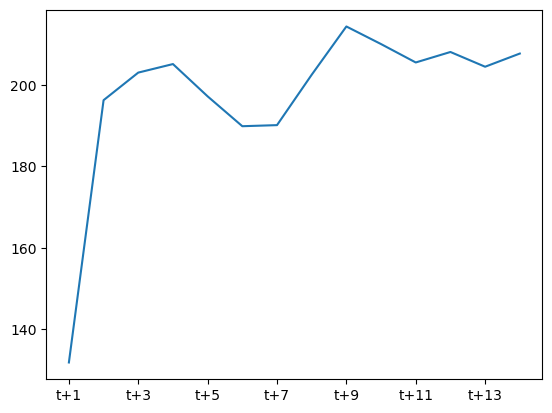

In [170]:
pd.Series(error_by_horizon_dir).plot()

Método Recursivo

In [171]:
model = Lasso()
print(Y_train['t+1'].head())
model.fit(X_train, Y_train['t+1'])

0    5114.833333
1    5656.625000
2    6279.208333
3    6321.875000
4    6414.208333
Name: t+1, dtype: float64


C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e+06, tolerance: 1.204e+04
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [173]:
Y_hat = pd.DataFrame(np.zeros((X_test.shape[0], 14)), columns=Y_train.columns)
Y_hat.head()

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
yh = model.predict(X_test)
Y_hat['t+1'] = yh

X_ = X_test.copy()
for i in range(2, 14 + 1):
    print('Antes')
    print(X_.head(3))
    X_.iloc[:, :-1] = X_.iloc[:, 1:].values
    X_['t-0'] = yh
    print('Depois')
    print(X_.head(3))

    yh = model.predict(X_)

    Y_hat[f't+{i}'] = yh

Antes
            t-41         t-40         t-39         t-38         t-37  \
344  5924.625000  6756.125000  6736.666667  6751.750000  6821.840000   
345  6756.125000  6736.666667  6751.750000  6821.840000  6245.583333   
346  6736.666667  6751.750000  6821.840000  6245.583333  5712.625000   

            t-36         t-35         t-34         t-33         t-32  ...  \
344  6245.583333  5712.625000  6246.750000  6858.666667  6935.791667  ...   
345  5712.625000  6246.750000  6858.666667  6935.791667  7036.375000  ...   
346  6246.750000  6858.666667  6935.791667  7036.375000  6927.208333  ...   

             t-9          t-8          t-7          t-6          t-5  \
344  6567.583333  6020.583333  5464.458333  6128.541667  6729.291667   
345  6020.583333  5464.458333  6128.541667  6729.291667  6728.875000   
346  5464.458333  6128.541667  6729.291667  6728.875000  6654.708333   

             t-4          t-3          t-2          t-1          t-0  
344  6728.875000  6654.708333  6584.

In [175]:
Y_hat.head()

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14
0,5713.481367,6211.123354,6512.160286,6422.241931,6194.741471,5870.501724,5338.099001,5484.143910,6074.458158,6401.917979,6621.925833,6594.876955,5932.811644,5425.837946
1,6506.520629,6669.922253,6541.330401,6293.969936,5941.625831,5420.658391,5644.789327,6221.674151,6500.894719,6691.586060,6644.305277,5992.083738,5477.828216,5695.162185
2,7032.392372,6734.913768,6440.098610,6063.385091,5507.931923,5746.094635,6418.795682,6681.537545,6813.036439,6729.782541,6052.735244,5550.558619,5758.957354,6202.686521
3,6606.499989,6371.517035,6011.615485,5464.795770,5715.175882,6382.905834,6611.702489,6749.039362,6686.755816,6022.452863,5529.071361,5733.190855,6180.085544,6376.815198
4,6873.386560,6279.647489,5667.122870,5883.761535,6503.743178,6751.967974,7021.970245,6936.870583,6190.610845,5647.421623,5817.167827,6280.786737,6465.144829,6874.256657


In [176]:
error_by_horizon_rec = {}
for h in Y_test.columns:
    error_by_horizon_rec[h] = mean_absolute_error(Y_test[h], Y_hat[h])
    
error_by_horizon_rec

{'t+1': 131.86127069522902,
 't+2': 194.09727493541573,
 't+3': 200.10390064985216,
 't+4': 200.16462205463282,
 't+5': 194.80234095197073,
 't+6': 187.730621775154,
 't+7': 183.6641256289228,
 't+8': 188.30471477359887,
 't+9': 192.54984991756706,
 't+10': 188.9867916854566,
 't+11': 185.67784401816283,
 't+12': 183.78288461938854,
 't+13': 180.55575655001854,
 't+14': 181.67813350822846}

In [177]:
pd.Series(error_by_horizon_rec).mean()

185.28286655454272

In [178]:
pd.Series(error_by_horizon_dir).mean()

197.5231843232275

O método recursivo apresenta um erro médio menor que o método direto. Observação: utilizamos o método lasso pois foi o que apresentou melhor desempenho individual.

Método Direto-Recursivo (DirRec

In [179]:
from sklearn.multioutput import RegressorChain

In [180]:
model = RegressorChain(Lasso())
model.fit(X_train, Y_train)

C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e+06, tolerance: 1.204e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+06, tolerance: 1.204e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\joaop\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.722e+06, toleranc

RegressorChain(base_estimator=Lasso())

In [181]:
forecasts_dr = model.predict(X_test)
forecasts_dr = pd.DataFrame(forecasts_dr, columns = Y_test.columns)
forecasts_dr.head()

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14
0,5713.481367,6264.106353,6429.191064,6340.844686,6228.237349,5864.365815,5300.662954,5560.126988,6233.914308,6319.573346,6543.570153,6584.335552,5884.961630,5437.771104
1,6506.520629,6579.475805,6506.360630,6359.462369,5972.660263,5419.048851,5736.483570,6338.019962,6336.102986,6524.853870,6594.165381,5916.164322,5476.001343,5740.362552
2,7032.392372,6754.529557,6470.716562,6103.076668,5519.749701,5818.296269,6559.411554,6673.594132,6852.485007,6893.605339,6124.570030,5659.143028,5875.158612,6208.385999
3,6606.499989,6374.618589,6036.666266,5449.886921,5753.209344,6500.675989,6574.164002,6727.050808,6788.510199,6036.229379,5594.734363,5816.205947,6158.201635,6466.907637
4,6873.386560,6299.462258,5636.828060,5915.870667,6613.867857,6690.611897,6989.037067,7039.428638,6212.396876,5728.370907,5928.727952,6281.161288,6564.991704,6831.366937


In [182]:
error_by_horizon_dr = {}
for h in Y_test.columns:
    error_by_horizon_dr[h] = mean_absolute_error(Y_test[h], forecasts_dr[h])
    
error_by_horizon_dr

{'t+1': 131.86127069522908,
 't+2': 196.24290838266776,
 't+3': 202.98584583763486,
 't+4': 205.0725496640228,
 't+5': 197.14355775258082,
 't+6': 189.81918970579568,
 't+7': 190.1006218062484,
 't+8': 202.45002166928842,
 't+9': 214.2885667241539,
 't+10': 209.97090411344206,
 't+11': 205.45479019133938,
 't+12': 208.02644955803592,
 't+13': 204.42938532941173,
 't+14': 207.63370105686096}

In [183]:
# pd.Series(error_by_horizon_dr)
pd.Series(error_by_horizon_dr).mean()

197.53426874905082

Percebe-se que o erro médio do método Dir-Rec ainda é maior do que o erro médio do método Recursivo.

In [ ]:
Método Multi-output

In [184]:
from sklearn.neighbors import KNeighborsRegressor
model_mo = KNeighborsRegressor()
model_mo.fit(X_train, Y_train)

KNeighborsRegressor()

In [185]:
forecasts_mo = model_mo.predict(X_test)
forecasts_mo = pd.DataFrame(forecasts_mo, columns = Y_test.columns)
forecasts_mo.head()

,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14
0,5584.225000,6200.141667,6383.866667,6460.725000,6485.141667,6088.675000,5435.866667,5653.591667,6100.550000,6297.900000,6500.691667,6540.200000,6076.508333,5409.300000
1,6112.266667,6190.491667,6383.475000,6404.991667,5868.433333,5170.691667,5606.966667,6050.758333,6130.925000,6342.133333,6377.508333,5812.891667,5123.091667,5483.141667
2,6369.475000,6406.041667,6399.316667,5853.908333,5178.016667,5630.300000,6121.908333,6238.025000,6479.291667,6549.058333,5996.591667,5345.216667,5774.991667,6179.691667
3,6406.041667,6399.316667,5853.908333,5178.016667,5630.300000,6121.908333,6238.025000,6479.291667,6549.058333,5996.591667,5345.216667,5774.991667,6179.691667,6230.725000
4,6399.316667,5853.908333,5178.016667,5630.300000,6121.908333,6238.025000,6479.291667,6549.058333,5996.591667,5345.216667,5774.991667,6179.691667,6230.725000,6407.533333


In [186]:
error_by_horizon_mo = {}
for h in Y_test.columns:
    error_by_horizon_mo[h] = mean_absolute_error(Y_test[h], forecasts_mo[h])
    
error_by_horizon_mo

{'t+1': 250.03567371719544,
 't+2': 269.1915295730513,
 't+3': 268.96771200548375,
 't+4': 277.2359479044261,
 't+5': 288.72975421073244,
 't+6': 286.56466412064236,
 't+7': 281.2222654719937,
 't+8': 276.00312132784956,
 't+9': 274.7595965530748,
 't+10': 267.83544114766937,
 't+11': 260.8158465530748,
 't+12': 259.0328062083823,
 't+13': 255.80696161378773,
 't+14': 254.31284358271316}

In [187]:
pd.Series(error_by_horizon_mo).mean()

269.3224402850055

In [188]:
print(f'Erro Direto: {pd.Series(error_by_horizon_dir).mean()}')
print(f'Erro Recursivo: {pd.Series(error_by_horizon_rec).mean()}')
print(f'Erro Direto-Recursivo: {pd.Series(error_by_horizon_dr).mean()}')
print(f'Erro Multi-output: {pd.Series(error_by_horizon_mo).mean()}')

Erro Direto: 197.5231843232275
Erro Recursivo: 185.28286655454272
Erro Direto-Recursivo: 197.53426874905082
Erro Multi-output: 269.3224402850055


Efetivamente o método recursivo foi o que apresentou menor erro médio nas previsões a longo prazo (período de 14 dias)

Vamos agora analisar o comportamennto dos valores extremos utilizando o método Lasso

In [198]:
series_tde_ext = UnivariateTDE(series_d, horizon=6, k=6)
series_tde_ext.head()

,t-5,t-4,t-3,t-2,t-1,t-0,t+1,t+2,t+3,t+4,t+5,t+6
0,4294.687500,5373.125000,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000
1,5373.125000,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667
2,6329.000000,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000
3,6538.708333,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000,5605.333333
4,6666.208333,6692.583333,6088.666667,5452.250000,6040.291667,6694.708333,6762.833333,6758.000000,6761.416667,6159.000000,5605.333333,6134.000000


In [199]:
is_future = series_tde_ext.columns.str.contains('\+')
X = series_tde_ext.iloc[:,~is_future]
y = series_tde_ext['t+6']

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [201]:
model = Lasso()
model.fit(X_train, y_train)

Lasso()

In [202]:
forecasts = model.predict(X_test)
forecasts

array([6007.67730121, 6558.55586285, 6556.98342745, 6503.83103178,
       6374.77231413, 5797.27445326, 5329.81659448, 5874.65667129,
       6619.70306399, 6759.17662745, 6829.00841816, 6853.52173265,
       6388.39689452, 5960.65212249, 6467.92088365, 6947.83072689,
       6861.55732556, 6818.68218128, 6720.66485059, 6155.94256594,
       5657.85660736, 6077.04774821, 6649.05661842, 6721.81563871,
       6715.24424541, 6435.21488464, 5885.92056313, 5412.45385762,
       5783.96860229, 6319.42224686, 6351.00590591, 6303.31659165,
       6321.73221296, 5864.92434888, 5300.68363762, 5527.3711803 ,
       5619.48972606, 5890.23118242, 6458.3170926 , 6410.44886269,
       5850.47922428, 5306.63998064, 5617.9735987 , 6145.43906513,
       6202.77639581, 6210.35088171, 6140.43458327, 5646.30669047,
       5167.24577602, 5608.39371051, 6224.80699794, 6226.88884395,
       6088.46919751, 5944.46572442, 5415.69504057, 4921.37065688,
       5325.36395939, 5890.731855  , 5913.41501229, 5904.54619

In [203]:
test_data = pd.DataFrame({'forecasts': forecasts, 'actual': y_test})
test_data.head()

,forecasts,actual
375,6007.677301,5953.333333
376,6558.555863,6800.833333
377,6556.983427,6928.125000
378,6503.831032,7014.000000
379,6374.772314,7109.833333


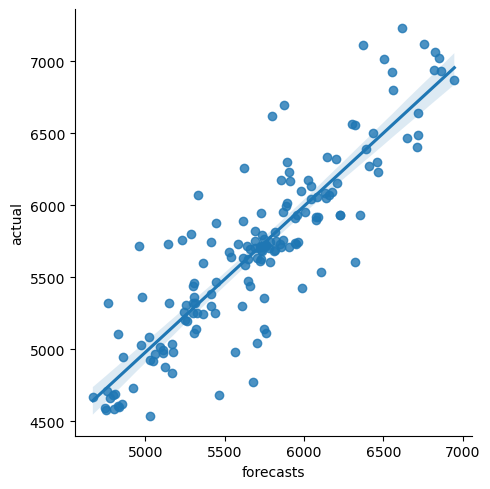

In [204]:
import seaborn as sns
sns.lmplot(x='forecasts', y='actual',data=test_data,fit_reg=True) 

In [205]:
from sklearn.metrics import mean_absolute_error, r2_score
from SRC.error import MASE

In [206]:
# MASE(y_train, y_test, forecasts)
mean_absolute_error(y_test, forecasts)

210.8642058226894

In [207]:
large_y_test = y_test[y_test > 5]
large_forecasts = forecasts[y_test > 5]
mean_absolute_error(large_y_test, large_forecasts)

210.8642058226894

In [208]:
r2_score(y_test, forecasts)

0.7740314517306515

In [209]:
r2_score(large_y_test, large_forecasts)

0.7740314517306515

Neste caso não se observou o aumento do erro em valores mais extremos, percebe-se que o erro é constante ao longo de todos os valores da regressão.